In [4]:
from pathlib import Path
import requests

DATA_PATH = Path("D:\AI\神经网络实战分类与回归任务\data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


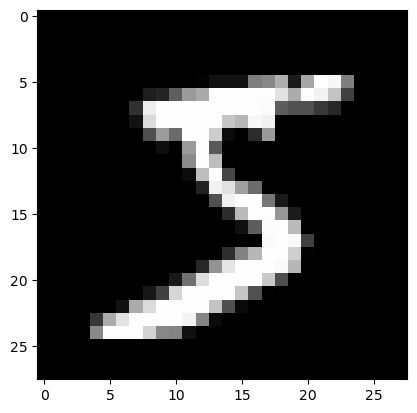

In [5]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


注意数据需转换成tensor才能参与后续建模训练

In [6]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

torch.nn.functional 很多层和函数在这里都会见到
torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [7]:
import torch.nn.functional as F

loss_func = F.cross_entropy


def model(xb):
    return xb.mm(weights) + bias

In [8]:
bs = 64
xb = x_train[0:bs]
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype=torch.float, requires_grad=True)
bias = torch.zeros(10, requires_grad=True)

print(loss_func(model(xb), yb))

tensor(14.9391, grad_fn=<NllLossBackward0>)


创建一个model来更简化代码
- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn


class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x


net = Mnist_NN()
print(net)

Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [10]:
for name, parameter in net.named_parameters():
    print(name, parameter, parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0338, -0.0320, -0.0278,  ...,  0.0111, -0.0286, -0.0191],
        [ 0.0234,  0.0019, -0.0166,  ..., -0.0298,  0.0082, -0.0304],
        [-0.0194, -0.0209,  0.0222,  ..., -0.0304,  0.0354,  0.0333],
        ...,
        [-0.0254,  0.0085, -0.0264,  ...,  0.0212, -0.0356, -0.0136],
        [ 0.0196, -0.0053,  0.0057,  ..., -0.0315,  0.0153, -0.0269],
        [ 0.0289, -0.0211,  0.0041,  ..., -0.0347,  0.0039, -0.0225]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0056, -0.0133,  0.0246,  0.0280, -0.0197, -0.0164, -0.0253, -0.0213,
         0.0263, -0.0241,  0.0073, -0.0032,  0.0162,  0.0138,  0.0073,  0.0262,
         0.0057,  0.0235,  0.0059,  0.0348,  0.0101,  0.0301, -0.0200, -0.0212,
         0.0319,  0.0046,  0.0305, -0.0276,  0.0082,  0.0134,  0.0203,  0.0016,
         0.0027, -0.0145,  0.0196,  0.0320,  0.0030,  0.0199, -0.0304, -0.0199,
         0.0097, -0.0140, -0.0297,  0.0066, 

使用TensorDataset和DataLoader来简

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)


def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [12]:
import numpy as np


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:' + str(step), '验证集损失：' + str(val_loss))

In [13]:
from torch import optim


def get_model():
    model = Mnist_NN()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [14]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：2.2788107345581055
当前step:1 验证集损失：2.2459096076965333
当前step:2 验证集损失：2.194839797973633
当前step:3 验证集损失：2.1110693035125734
当前step:4 验证集损失：1.9735412372589112
当前step:5 验证集损失：1.76572336063385
当前step:6 验证集损失：1.5013155405044556
当前step:7 验证集损失：1.235018564224243
当前step:8 验证集损失：1.0191831329345704
当前step:9 验证集损失：0.8622355289459228
当前step:10 验证集损失：0.7513635157585145
当前step:11 验证集损失：0.6717747295379639
当前step:12 验证集损失：0.6122910155296326
当前step:13 验证集损失：0.5670241856575012
当前step:14 验证集损失：0.5317905701160431
当前step:15 验证集损失：0.5026024229049683
当前step:16 验证集损失：0.47855639362335206
当前step:17 验证集损失：0.45873655767440796
当前step:18 验证集损失：0.44151957988739016
当前step:19 验证集损失：0.42745458011627196
当前step:20 验证集损失：0.4143767005443573
当前step:21 验证集损失：0.40335682253837585
当前step:22 验证集损失：0.39313514273166655
当前step:23 验证集损失：0.384419727563858
当前step:24 验证集损失：0.37665460262298583
